<a href="https://www.kaggle.com/code/anshtanwar/transfer-learning-fungi-image?scriptVersionId=138918683" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="border-radius: 10px; border: #E57C23; : padding: 10px; background-color: #FFFAF0; font-size: 120%; text-align: left;">
    <p style="font-weight: bold; margin-bottom: 10px;">Content:</p>
    <ol style="list-style-type: decimal; padding-left: 15px;">
        <li><a href="#Importing-The-Modules" style="color: #E75480; text-decoration: none;">📩 Importing The Modules</a></li>
        <li><a href="#Data-Augmentation-and-Preprocessing" style="color: #E75480; text-decoration: none;">📅 Data Loading, Augmentation and Preprocessing</a></li>
        <li><a href="#Training-and-Evaluation" style="color: #E75480; text-decoration: none;">🧠 Training and Evaluation</a></li>
        <li><a href="#Learning-and-Accuracy-Curve" style="color: #E75480; text-decoration: none;">📉 Learning and Accuracy Curve</a></li>
    </ol>
</div>


## <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Dont forget to upvote if you liked the notebook</div>

In [1]:
!python -m pip install tensorflow tensorflow-addons


# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Importing The Modules</div>

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Data Augmentation and Preprocessing</div>

In [3]:
# Kernel Reference: https://www.kaggle.com/code/gpiosenka/explore-and-augment-pet-face-dataset


def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(255,255,255), same_line=False):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    if same_line:        
        print(msg .format(mat), end='', flush=True)# does not go to a new line so next print is on the same line
    else:        
        print(msg .format(mat), flush=True)
    print('\33[0m', end='',flush=True) # returns default print color to back to black
    return


def explore():
    train_dir="/kaggle/input/microscopic-fungi-images"
    if train_dir == '':
        train_dir=input('enter the full path to the directory containing the training images')
        test_ans=input('enter the full path to the directory containing the test images, if there are no test images press Enter')
        valid_ans=input(' enter the full path to the directory containing the validation images, if there are no validation images press Enter')
        if test_ans == '' and valid_ans=='':
            dir_list=[train_dir]
            names=['train']
        elif test_ans == '' and valid_ans != '':
            dir_list=[train_dir, valid_ans]
            names=['train', 'valid']
        elif test_ans != '' and valid_ans =='':
            dir_list=[train_dir, test_ans]
            names=['train', 'test']
        else:
            dir_list=[train_dir, test_ans, valid_ans]
            names=['train', 'test', 'valid']
    else:
        dir_list=[train_dir]
        names=['train']
    classes= sorted(os.listdir(train_dir))
    class_count=len(classes)    
    train_total=0
    test_total=0
    valid_total=0
    smallest_count=1000000
    largest_count=0
    msg='{0:^10s}{1:^40s}{2:^18s}{3:^18s}{4:^18s}'
    msg=msg.format('Class Id', 'Class', 'Train ','Test', 'Valid ')
    print_in_color(msg, (0,255,255), (0,0,0))
    for i, klass in enumerate(classes):
        tr_count=0
        te_count=0
        v_count=0          
        for d in dir_list:             
            classpath=os.path.join(d, klass)               
            flist= os.listdir(classpath)
            length = len(flist)        
            if 'train' in d or len(dir_list)==1:
                tr_count = length
                train_total += length
                if length > largest_count:
                    largest_count=length
                    largest_class=klass
                if length < smallest_count:
                    smallest_count=length
                    smallest_class=klass
            elif 'test' in d:
                te_count = length
                test_total +=length
            else:
                valid_total += length
                v_count = length
        msg='{0:^10s}{1:^40s}{2:^18s}{3:^18s}{4:^18s}'.format(str(i) ,klass, str(tr_count), str(te_count),str(v_count))
        toggle=i % 2   
        if toggle==0:
            back_color=(255,255,255)
        else:
            back_color=(191, 239, 242)
        print_in_color(msg, (0,0,0), back_color)
    print('{0:60s}'.format('-'))
    msg='{0:^10s}{1:^40s}{2:^18s}{3:^18s}{4:^18s}'
    msg=msg.format('TOTALS', str(class_count), str(train_total), str(test_total), str(valid_total))
    print (msg)
    print ('class ',largest_class,' has the most files= ',largest_count, ' class ', smallest_class, ' has the leat files= ', smallest_count)
    #print('\33[0m') 
    height=int(class_count/2)
    fig = plt.figure(figsize=(20,height))
    if class_count % 5==0:
        rows=int(class_count/5)
    else:
        rows=int(class_count/5) +1    
    for row in range(rows):
        for column in range(5):
            i= row * 5 + column         
            if i>class_count-1:
                break            
            klass=classes[i]
            classpath=os.path.join(train_dir, klass)
            flist=os.listdir(classpath)            
            f_path=os.path.join(classpath, flist[0])             
            img = mpimg.imread(f_path)
            a = fig.add_subplot(rows, 5, i+1)
            imgplot=plt.imshow(img)
            a.axis("off")
            a.set_title(klass)	

 Class Id                  Class                        Train              Test             Valid       
    0                        H1                          4404               0                 0         
    1                        H2                          2334               0                 0         
    2                        H3                          819                0                 0         
    3                        H5                          818                0                 0         
    4                        H6                          739                0                 0         
-                                                           
  TOTALS                     5                           9114               0                 0         
class  H1  has the most files=  4404  class  H6  has the leat files=  739


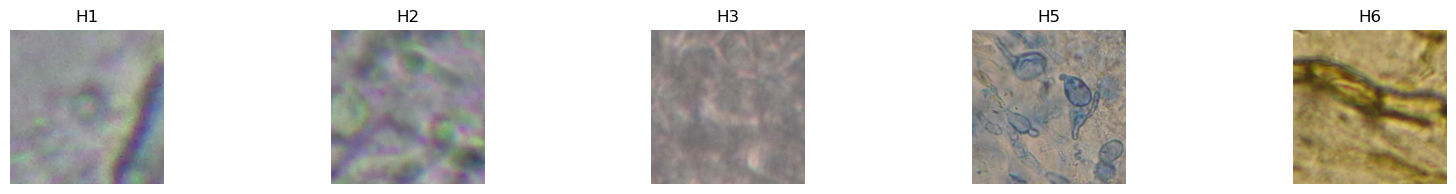

In [4]:
explore()

### The data set is not completely balanced. It also has a limited number of images per class so augmentation is recommended.

In [5]:
# Kernel Reference: https://www.kaggle.com/code/gpiosenka/explore-and-augment-pet-face-dataset
import pandas as pd
import numpy as np
import albumentations as A 
import shutil
import skimage
sdir="/kaggle/input/microscopic-fungi-images"
working_dir="/kaggle/working/"
dest_dir=os.path.join(working_dir, 'balanced dataset')
print(f'the balanced dataset will be saved to {dest_dir}')
if os.path.isdir(dest_dir):
    shutil.rmtree(dest_dir) # start with a clean empty dest_dir
os.mkdir(dest_dir) 
limiter=500
print(f'the dataset will be balanced to have {limiter} image files in each class')
classes=sorted(os.listdir(sdir))# make a list of the classes
class_count=len(classes)# number of classes
bad_img_list=[]
ht=0
wt=0
good_file_count=0
for klass in classes: # iterate through the classes
    classpath=os.path.join(sdir,klass)
    dest_classpath=os.path.join(dest_dir, klass)
    os.mkdir(dest_classpath) # make a directory in the dest_dir for this class
    flist=sorted(os.listdir(classpath))# get list of files in each class    
    fcount=len(flist) 
    if fcount>limiter: # if the number of files is greator than the limiter sample the file list to have limiter number of files
        flist=np.random.choice(flist, limiter, replace=False)
    fprocesseed=0
    for f in (flist): # iterate through the files in each class
        msg=f'processing {fcount} files for class {klass}, {str(fprocesseed)} processed               ' 
        print(msg, '\r', end='')        
        fpath=os.path.join(classpath,f)
        dest_fpath=os.path.join(dest_classpath, f) # where to store the file
        try: # test if the image file can be read if so save it to the dest_dir
            img= skimage.io.imread(fpath)            
            shape=img.shape 
            ht += shape[0]
            wt += shape[1]
            good_file_count +=1
            fprocesseed +=1
            shutil.copy(fpath,  dest_fpath)  
        except: # if the image file can not be read store the path in the bad_img_list
            bad_img_list.append(fpath)
if len(bad_img_list)>0:
    print(f'the image files listed below could not be processed and were not included in the balanced dataset')
    for f in bad_img_list:
        print (f)
have=int(ht/good_file_count)
wave=int(wt/good_file_count)
print(f'the average height of the images= {have} the average_width of the images = {wave}')
# some files in the original dataset may have been invalid image files and were not copied to the destination directory
# so go through the destination directory and determine how many files are in each class and store in fcount_list

classes=sorted(os.listdir(dest_dir))
fcount_list=[]# list to store how many files are in each class
for klass in classes:
    classpath=os.path.join(dest_dir, klass)
    flist=sorted(os.listdir(classpath))
    file_count=len(flist)
    fcount_list.append(file_count)
zip_list=zip(fcount_list,classes)
ordered_list=sorted(zip_list) # order the list by the number of files
fc='File Count'
k='Class'
print(f'the dataset has {class_count} classes listed below:')
print(f'{fc:^12s}{k:^45s}')
classes=[]
fcount=[]
ft=0 # total number of files in train dataset
for count, klass in ordered_list:
    fcount.append(count)
    ft += count
    classes.append(klass)
    strcount=str(count)
    print(f'{strcount:^12s}{klass:^45s}')
min_class=classes[0]
min_count=fcount[0]
length=len(classes)-1
max_class=classes[length]
max_count=fcount[length]
print(f'class {max_class} has the most image files= {max_count}, class {min_class} has the least images= {min_count}')
fneeded= len(classes)* limiter
aug_imgs_needed= fneeded-ft
print(f'{aug_imgs_needed}augmented images need to be created, if images are large this may take a considerable amount of time ')
# lets define a function that creates an augmented image

def get_augmented_image(image): # given an image this function returns an augmented image
    width=int(image.shape[1]*.8)
    height=int(image.shape[0]*.8)
    transform= A.Compose([
        A.HorizontalFlip(p=.5),
        A.Rotate(limit=30, p=.25),
        A.RandomBrightnessContrast(p=.5),
        A.RandomGamma(p=.5),
        A.RandomCrop(width=width, height=height, p=.25) ])    
    return transform(image=image)['image']

# Iterate through the classes, for a class with less than limiter number image files create augmented images
# so each class has limiter number of image files
no_save_list=[]
dummy_path=os.path.join(working_dir, 'dummy')
if os.path.isdir(dummy_path):
    shutil.rmtree(dummy_path)
os.mkdir(dummy_path)
for count, klass in ordered_list:
    aug_counter=0
    i= -1
    if count < limiter: # if this class has less than the limiter value of files
        delta=limiter - count # this is how many augmented images we need to create for this class 
        classpath=os.path.join(dest_dir,klass)# path to class
        dest_classpath=os.path.join(dest_dir,klass) # where to store files for this class  
        dummy_classpath=os.path.join(dummy_path, klass)
        os.mkdir(dummy_classpath)
        flist=sorted(os.listdir(classpath))# get list of files for this class         
        while aug_counter<delta:
            i +=1 
            j=i % count # delta may be greator than the number of files in the class so use mod of count as file indexer
            fpath=os.path.join(classpath, flist[j]) # path to the image file to augment
            
            # give the augmented image a unique file name
            dest_fpath=os.path.join(dest_classpath,'aug-'+str(i)+'-'+ flist[j])# path of where to store the augmented image
            dummy_fpath=os.path.join(dummy_classpath,'aug-'+str(i)+'-'+ flist[j])
            try:                
                img= skimage.io.imread(fpath)
                aug_img=get_augmented_image(img) # augment the image 
                skimage.io.imsave(dummy_fpath, aug_img)
                skimage.io.imsave(dest_fpath, aug_img) # save the augmented image
                aug_counter +=1
                msg=f'creating {delta} augmented images for class {klass}, {str(aug_counter)} created              '                     '                                                 '
                print(msg, '\r', end='')
            except:
                no_save_list.append(fpath)
print(f'the balanced dataset with {limiter} image files in each class is stored in {dest_dir} ') 
shutil.rmtree(dummy_path)

the balanced dataset will be saved to /kaggle/working/balanced dataset
the dataset will be balanced to have 500 image files in each class
the average height of the images= 500 the average_width of the images = 500
the dataset has 5 classes listed below:
 File Count                     Class                    
    500                          H1                      
    500                          H2                      
    500                          H3                      
    500                          H5                      
    500                          H6                      
class H6 has the most image files= 500, class H1 has the least images= 500
0augmented images need to be created, if images are large this may take a considerable amount of time 
the balanced dataset with 500 image files in each class is stored in /kaggle/working/balanced dataset 


In [6]:
# Kernel Reference: https://www.kaggle.com/code/gpiosenka/explore-and-augment-pet-face-dataset


def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(255,255,255), same_line=False):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    if same_line:        
        print(msg .format(mat), end='', flush=True)# does not go to a new line so next print is on the same line
    else:        
        print(msg .format(mat), flush=True)
    print('\33[0m', end='',flush=True) # returns default print color to back to black
    return


def explore():
    train_dir="/kaggle/working/balanced dataset"
    if train_dir == '':
        train_dir=input('enter the full path to the directory containing the training images')
        test_ans=input('enter the full path to the directory containing the test images, if there are no test images press Enter')
        valid_ans=input(' enter the full path to the directory containing the validation images, if there are no validation images press Enter')
        if test_ans == '' and valid_ans=='':
            dir_list=[train_dir]
            names=['train']
        elif test_ans == '' and valid_ans != '':
            dir_list=[train_dir, valid_ans]
            names=['train', 'valid']
        elif test_ans != '' and valid_ans =='':
            dir_list=[train_dir, test_ans]
            names=['train', 'test']
        else:
            dir_list=[train_dir, test_ans, valid_ans]
            names=['train', 'test', 'valid']
    else:
        dir_list=[train_dir]
        names=['train']
    classes= sorted(os.listdir(train_dir))
    class_count=len(classes)    
    train_total=0
    test_total=0
    valid_total=0
    smallest_count=1000000
    largest_count=0
    msg='{0:^10s}{1:^40s}{2:^18s}{3:^18s}{4:^18s}'
    msg=msg.format('Class Id', 'Class', 'Train ','Test', 'Valid ')
    print_in_color(msg, (0,255,255), (0,0,0))
    for i, klass in enumerate(classes):
        tr_count=0
        te_count=0
        v_count=0          
        for d in dir_list:             
            classpath=os.path.join(d, klass)               
            flist= os.listdir(classpath)
            length = len(flist)        
            if 'train' in d or len(dir_list)==1:
                tr_count = length
                train_total += length
                if length > largest_count:
                    largest_count=length
                    largest_class=klass
                if length < smallest_count:
                    smallest_count=length
                    smallest_class=klass
            elif 'test' in d:
                te_count = length
                test_total +=length
            else:
                valid_total += length
                v_count = length
        msg='{0:^10s}{1:^40s}{2:^18s}{3:^18s}{4:^18s}'.format(str(i) ,klass, str(tr_count), str(te_count),str(v_count))
        toggle=i % 2   
        if toggle==0:
            back_color=(255,255,255)
        else:
            back_color=(191, 239, 242)
        print_in_color(msg, (0,0,0), back_color)
    print('{0:60s}'.format('-'))
    msg='{0:^10s}{1:^40s}{2:^18s}{3:^18s}{4:^18s}'
    msg=msg.format('TOTALS', str(class_count), str(train_total), str(test_total), str(valid_total))
    print (msg)
    print ('class ',largest_class,' has the most files= ',largest_count, ' class ', smallest_class, ' has the leat files= ', smallest_count)
    #print('\33[0m') 
    height=int(class_count/2)
    fig = plt.figure(figsize=(20,height))
    if class_count % 5==0:
        rows=int(class_count/5)
    else:
        rows=int(class_count/5) +1    
    for row in range(rows):
        for column in range(5):
            i= row * 5 + column         
            if i>class_count-1:
                break            
            klass=classes[i]
            classpath=os.path.join(train_dir, klass)
            flist=os.listdir(classpath)            
            f_path=os.path.join(classpath, flist[0])             
            img = mpimg.imread(f_path)
            a = fig.add_subplot(rows, 5, i+1)
            imgplot=plt.imshow(img)
            a.axis("off")
            a.set_title(klass)	

 Class Id                  Class                        Train              Test             Valid       
    0                        H1                          500                0                 0         
    1                        H2                          500                0                 0         
    2                        H3                          500                0                 0         
    3                        H5                          500                0                 0         
    4                        H6                          500                0                 0         
-                                                           
  TOTALS                     5                           2500               0                 0         
class  H1  has the most files=  500  class  H1  has the leat files=  500


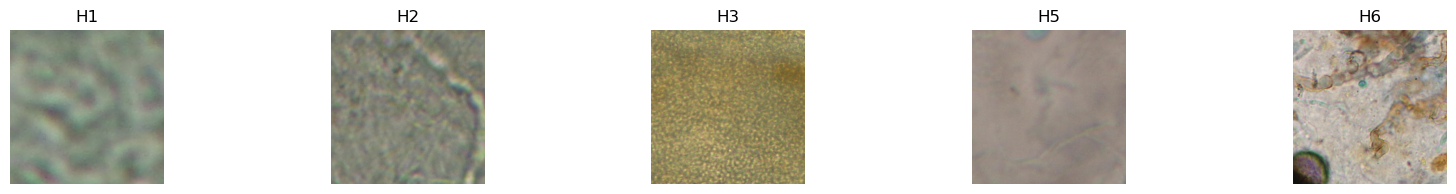

In [7]:
explore()

In [8]:
H1 = "/kaggle/working/balanced dataset/H1"
H2 = "/kaggle/working/balanced dataset/H2"
H3 = "/kaggle/working/balanced dataset/H3"
H5 = "/kaggle/working/balanced dataset/H5"
H6 = "/kaggle/working/balanced dataset/H6"

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

H1_images = load_images_from_folder(H1)
H1_labels =  [0] * len(H1_images)

H2_images = load_images_from_folder(H2)
H2_labels =  [1] * len(H2_images)

H3_images = load_images_from_folder(H3)
H3_labels =  [2] * len(H3_images)

H5_images = load_images_from_folder(H5)
H5_labels =  [3] * len(H5_images)

H6_images = load_images_from_folder(H6)
H6_labels =  [4] * len(H6_images)




# Combine all images and labels
all_images = H1_images+H2_images+H3_images+H5_images+H6_images
all_labels = H1_labels+H2_labels+H3_labels+H5_labels+H6_labels

In [9]:
len(H1_labels)

500

In [10]:
X = np.array(H1_images+H2_images+H3_images+H5_images+H6_images)
y = np.array(H1_labels+H2_labels+H3_labels+H5_labels+H6_labels)
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = to_categorical(y, 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
input_shape_resnet = (224, 224, 3)
input_shape_densenet = (224, 224, 3)
input_shape_efficientnet = (224, 224, 3)

def resize_images(images, input_shape):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, (input_shape[0], input_shape[1]))
        img_resized = np.expand_dims(img_resized, axis=-1)
        img_resized = np.repeat(img_resized, 3, axis=-1)  # Add three channels to convert grayscale to RGB
        resized_images.append(img_resized)
    return np.array(resized_images)

X_train_resized_resnet = resize_images(X_train, input_shape_resnet)



In [12]:
X_train_resized_densenet = resize_images(X_train, input_shape_densenet)


In [13]:
X_train_resized_efficientnet = resize_images(X_train, input_shape_efficientnet)

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Training and Evaluation</div>

<div style="background-color:#ffb7cc; padding: 20px;">For ResNet, DenseNet, and EfficientNet, we first load their pre-trained versions from the Keras library with weights trained on ImageNet. We remove their top classification layer, which was originally designed for ImageNet's 1000 classes, and add our custom classification head tailored for our task with three output classes (happy, sad, and angry). This new classification head is appended to the base models' output using global average pooling to extract meaningful features from the images.After adding the custom classification head, we compile each model using categorical cross-entropy as the loss function and the Adam optimizer</div>

In [14]:
# Load pre-trained ResNet50 model and remove the top classification layer
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)
resnet_base_model.trainable = False

# Add custom classification head to the ResNet model
resnet_global_avg_pooling = GlobalAveragePooling2D()(resnet_base_model.output)
resnet_output = Dense(5, activation='softmax')(resnet_global_avg_pooling)
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

# Compile the ResNet model
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_densenet)
densenet_base_model.trainable = False


densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_output = Dense(5, activation='softmax')(densenet_global_avg_pooling)
densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)


densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape_efficientnet)
efficientnet_base_model.trainable = False


efficientnet_global_avg_pooling = GlobalAveragePooling2D()(efficientnet_base_model.output)
efficientnet_output = Dense(5, activation='softmax')(efficientnet_global_avg_pooling)
efficientnet_model = Model(inputs=efficientnet_base_model.input, outputs=efficientnet_output)


efficientnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-7)

# Train the models
'''
train the models on resized training data and validation split,
monitoring the validation loss and using the
early stopping and learning rate scheduling callbacks to stop when necessary.
'''

resnet_history = resnet_model.fit(X_train_resized_resnet, y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks=[early_stopping, lr_scheduler])
densenet_history = densenet_model.fit(X_train_resized_densenet, y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks=[early_stopping, lr_scheduler])
efficientnet_history = efficientnet_model.fit(X_train_resized_efficientnet, y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks=[early_stopping, lr_scheduler])



16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/100
50/50 [==============================] - 20s 172ms/step - loss: 1.6487 - accuracy: 0.2044 - val_loss: 1.6045 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 6s 122ms/step - loss: 1.6217 - accuracy: 0.1919 - val_loss: 1.6082 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 6s 118ms/step - loss: 1.6168 - accuracy: 0.2262 - val_loss: 1.6082 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 6s 120ms/step - loss: 1.6172 - accuracy: 0.1931 - val_loss: 1.6207 - val_accuracy: 0.2025 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 6s 121ms/step - loss: 1.6098 - accuracy: 0.2212 - val_loss: 1.6299 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 6s 122ms/step - loss: 1.6131 - accuracy: 0.2163 - val_loss: 1.6123 - val_accuracy: 0.2875 - lr: 0.001

2023-08-04 17:09:18.928344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 14s 156ms/step - loss: 1.6326 - accuracy: 0.1813 - val_loss: 1.6163 - val_accuracy: 0.2025 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 4s 89ms/step - loss: 1.6280 - accuracy: 0.2094 - val_loss: 1.6235 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 4s 89ms/step - loss: 1.6294 - accuracy: 0.1844 - val_loss: 1.6206 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 4s 90ms/step - loss: 1.6230 - accuracy: 0.1988 - val_loss: 1.6370 - val_accuracy: 0.1625 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 4s 89ms/step - loss: 1.6222 - accuracy: 0.1950 - val_loss: 1.6235 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 4s 79ms/step - loss: 1.6254 - accuracy: 0.1863 - val_loss: 1.6213 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 4s 84ms/step - loss: 1.6200

In [15]:
# Resize test images to the input shape required by each model
X_test_resized_densenet = resize_images(X_test, input_shape_densenet)
X_test_resized_resnet = resize_images(X_test, input_shape_resnet)
X_test_resized_efficientnet = resize_images(X_test, input_shape_efficientnet)

# Evaluate the models on test data
densenet_loss, densenet_accuracy = densenet_model.evaluate(X_test_resized_densenet, y_test)
resnet_loss, resnet_accuracy = resnet_model.evaluate(X_test_resized_resnet, y_test)
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(X_test_resized_efficientnet, y_test)

print("\n")
print("DenseNet Test accuracy:", densenet_accuracy)
print("ResNet Test accuracy:", resnet_accuracy)
print("EfficientNet Test accuracy:", efficientnet_accuracy)

16/16 [==============================] - 2s 110ms/step - loss: 1.6098 - accuracy: 0.2220


DenseNet Test accuracy: 0.6399999856948853
ResNet Test accuracy: 0.29600000381469727
EfficientNet Test accuracy: 0.22200000286102295


# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Learning and Accuracy Curve</div>

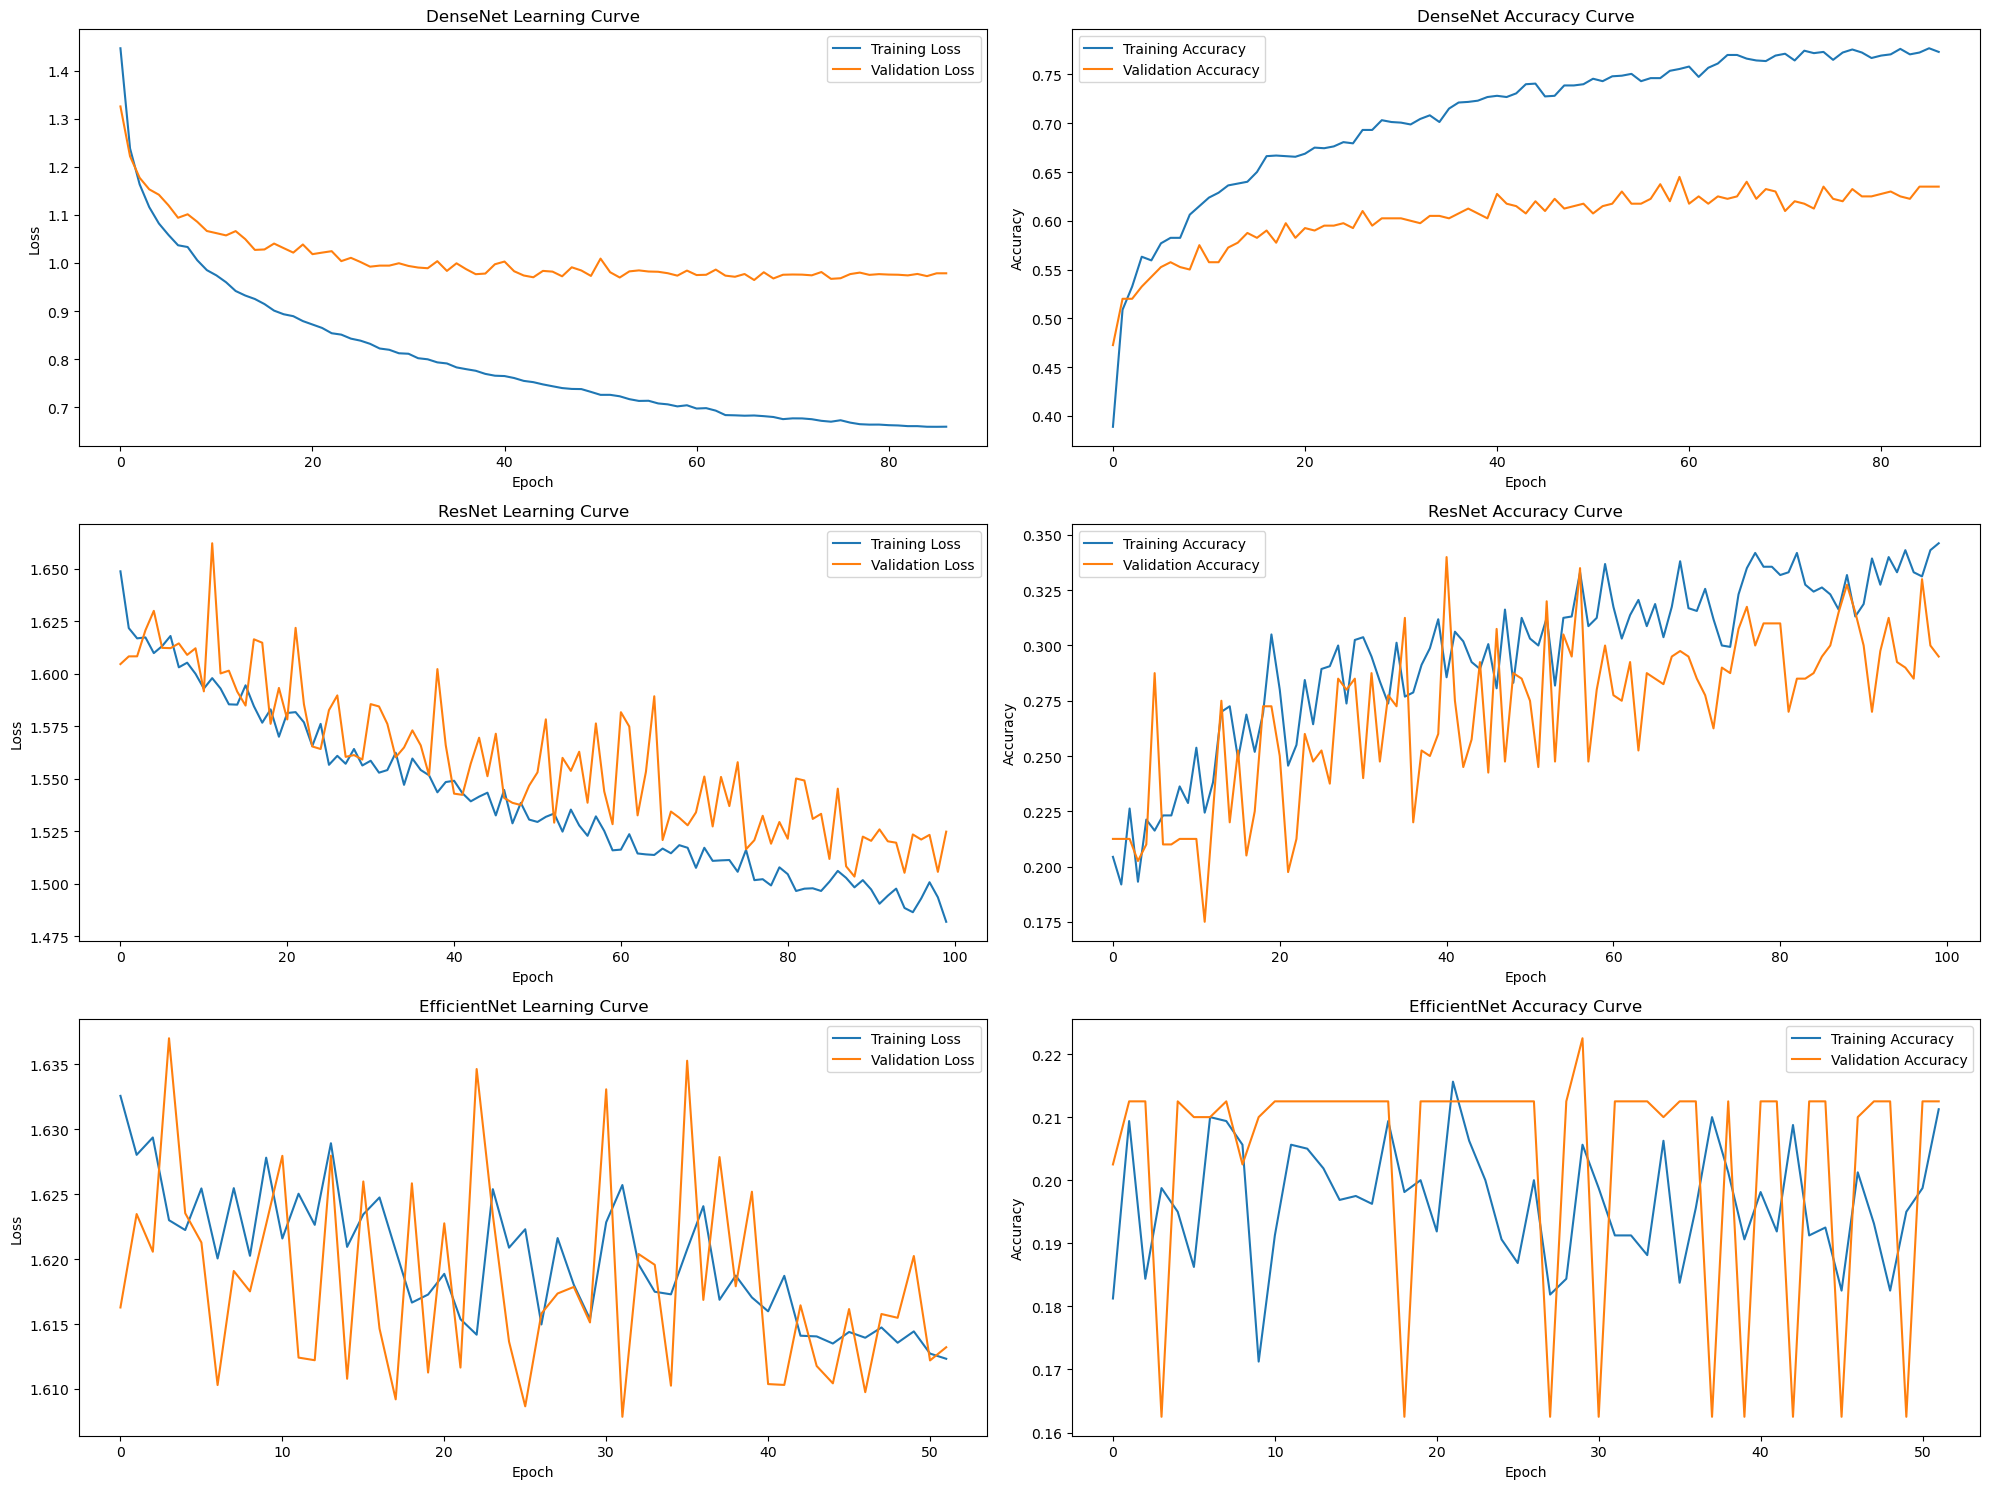

In [16]:
import matplotlib.pyplot as plt


def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()


def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()


fig, axs = plt.subplots(3, 2, figsize=(20, 15))
plot_learning_curves(densenet_history, 'DenseNet', axs[0, 0])
plot_accuracy_curves(densenet_history, 'DenseNet', axs[0, 1])

plot_learning_curves(resnet_history, 'ResNet', axs[1, 0])
plot_accuracy_curves(resnet_history, 'ResNet', axs[1, 1])

plot_learning_curves(efficientnet_history, 'EfficientNet', axs[2, 0])
plot_accuracy_curves(efficientnet_history, 'EfficientNet', axs[2, 1])

plt.tight_layout()
plt.show()
